In [18]:
import random as random
import Bio
import numpy as np
import sys
import os
import networkx as nx
import random as random
from tqdm import tqdm # loading bar
from utils_copy import linear_C, get_cost_2, get_sequence_string, parse_fasta_multiple, create_score_matrix, write_alignments_to_file, linear_backtrack, fill_graph,new_sp_approxi_combi
from utils_copy import convert_to_desired_format_nr_version, compute_cost, my_traversal_simply, extend_alignment_chaos, find_min_span_edges_testing, parse_fasta_multiple_remove_n
import timeit
from utils_copy import al_integrity_testt
from old_for_testing.sp_approx import sp_approx
from old_for_testing.utils import *
from functions_multiple_version import *
import matplotlib.pyplot as plt
import pandas as pd

score_matrix={'a': {'a': 0, 'c': 5, 'g': 2, 't': 5}, 'c': {'a': 5, 'c': 0, 'g': 5, 't': 2}, 'g': {'a': 2, 'c': 5, 'g': 0, 't': 5}, 't': {'a': 5, 'c': 2, 'g': 5, 't': 0}}
gap_cost=5



In [19]:
def make_related_strings(nr_of_str:int,len_of_str, degree_of_variation:float, start_string):
    string_fam_collection=[]
    first_string=[]
    if start_string==False:
        for k in range(0,int(len_of_str)):
                first_string.append(random.choice(['a','c','t','g']))
        first_string=''.join(first_string)
        string_fam_collection.append(first_string)
    else:
         first_string=start_string
         string_fam_collection.append(first_string)

    for i in range(1,nr_of_str):
        a_sequence=[]
        for element in first_string:
            if random.random() < degree_of_variation: #checking if we should change the charachter
                a_sequence.append(random.choice(['a','c','t','g']))
            else:
                 a_sequence.append(element)
        a_sequence=''.join(a_sequence)
        string_fam_collection.append(a_sequence)
    return string_fam_collection

#make_related_strings(3,12,0.1,False)


def make_strings_in_families(nr_of_fams, nr_str_pr_fam, len_of_str, internal_var_in_fams, degree_of_var_from_first_fam):
    all_strings_coll = []
    first_family = make_related_strings(nr_str_pr_fam, len_of_str, internal_var_in_fams[0], start_string=False)
    all_strings_coll.append(first_family)
    
    for i in range(1, int(nr_of_fams)):
        carry_over_string = first_family[0]
        mutated_carry_over = []
        for element in carry_over_string:
            if random.random() < degree_of_var_from_first_fam[i]:  # checking if we should change the character
                mutated_carry_over.append(random.choice(['a', 'c', 't', 'g']))
            else:
                mutated_carry_over.append(element)
        mutated_carry_over = ''.join(mutated_carry_over)  # Join the list of characters into a string
        family = make_related_strings(nr_str_pr_fam, len_of_str, internal_var_in_fams[i],mutated_carry_over)
        all_strings_coll.append(family)
    all_strings_coll = [item for sublist in all_strings_coll for item in sublist]
    #all_strings_coll = [''.join(sublist) for sublist in all_strings_coll]
    return all_strings_coll

make_strings_in_families(3, 2, 15, [0.1, 0.1,0.1], [0, 0.9,0.5])


['ggagtctctactgcc',
 'ggattccctactggt',
 'cagataactagagaa',
 'cagataactagagaa',
 'ggagtgcctagtgct',
 'ggagtgcctagtgct']

In [20]:
def test_many_parameters(nr_of_str=10, repeats=20,len_str=20,nr_of_fams=2, str_pr_fam=5, internal_var=0.1, var_between_fams=0.9,mode='random' ):
    if mode=='random':
        random_sequences_collection=[]
        for i in range(0,repeats):
            random_pile=[]
            for j in range (0,nr_of_str):
                a_sequence=[]
                for k in range(0,len_str):
                    a_sequence.append(random.choice(['a','c','t','g']))
                a_sequence=''.join(a_sequence)
                random_pile.append(a_sequence)
            random_sequences_collection.append(random_pile)
        costs_new_gradual=[]
        costs_new_one_by_one=[]
        costs_old=[]
        for random_pile in random_sequences_collection:
            print('rand: I intend to align: '+str(random_pile))
            cost=new_assembly(random_pile,score_matrix,gap_cost)[4]
            costs_new_gradual.append(cost)
        for random_pile in random_sequences_collection:
            cost=new_sp_approxi_combi(random_pile,score_matrix,gap_cost)[0]
            costs_new_one_by_one.append(cost)
        for random_pile in random_sequences_collection:
            print('rand:I intend to align: '+str(random_pile))
            cost=sp_approx(random_pile,score_matrix,gap_cost)[0]
            costs_old.append(cost)
    elif mode=='family':
        internal_var=[internal_var]*nr_of_fams
        var_between_fams=[var_between_fams]*nr_of_fams
        strings_in_families=make_strings_in_families(nr_of_fams,str_pr_fam,len_str,internal_var,var_between_fams)
        costs_new_gradual=[]
        costs_new_one_by_one=[]
        costs_old=[]
       # for random_pile in strings_in_families:
        print('fam:I intend to align: '+str(strings_in_families))
        cost=new_assembly(strings_in_families,score_matrix,gap_cost)[4]
        costs_new_gradual.append(cost)
        #    cost=new_assembly(random_pile,score_matrix,gap_cost)[4]
         #   costs_new_gradual.append(cost)
        #for random_pile in strings_in_families:
        cost=new_assembly_OBO(strings_in_families,score_matrix,gap_cost)[4]
        costs_new_one_by_one.append(cost)
        #for random_pile in strings_in_families:
        print('fam:I intend to align: '+str(strings_in_families))
        #    cost=sp_approx(random_pile,score_matrix,gap_cost)[0]
        #    costs_old.append(cost)
        cost=sp_approx(strings_in_families,score_matrix,gap_cost)[0]
        costs_old.append(cost)
        
    else:
        print("that's not a valid mode, try 'family' or 'random'!")
    #result=costs_new_gradual, costs_new_one_by_one, costs_old
    result=costs_new_gradual,costs_new_one_by_one,costs_old
    if mode=='random':
        params="nr str: "+ str(nr_of_str)+", repeats: "+str(repeats)+", str len: "+str(len_str)+", nr fams: NA, str_pr_fam: NA, internal var: NA, var between fams: NA, mode:"+str(mode)
    if mode=='family':
        params="nr str: NA, repeats: "+str(repeats)+", str len: "+str(len_str)+", nr fams: "+str(nr_of_fams)+", str_pr_fam: "+str(str_pr_fam)+", internal var: "+ str(internal_var[0])+", var between fams: "+str(var_between_fams[0])+", mode:"+str(mode)
    return params, result

test_many_parameters(repeats=2,len_str=15,nr_of_fams=3,str_pr_fam=3,internal_var=0.1,var_between_fams=0.9, mode='family')
    
        

fam:I intend to align: ['tgtcttagacacgct', 'tgttttagacacagt', 'tgtctcagacacgct', 'aatctgccagaatat', 'actctgccagtatat', 'aatccgccagaatat', 'ttttttattcacaca', 'ttttttattcacata', 'tttatttatcacaga']
Here comes the distance matrix produced by the alignments: 

[[ 0.  9.  2. 33. 37. 35. 24. 26. 34.]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]]
Here comes the distance matrix produced by the alignments: 

[[ 0.  9.  2. 33. 37. 35. 24. 26. 34.]
 [ 9.  0. 11. 33. 35. 35. 25. 25. 25.]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan n

('nr str: NA, repeats: 2, str len: 15, nr fams: 3, str_pr_fam: 3, internal var: 0.1, var between fams: 0.9, mode:family',
 ([1104], [1104], [1192]))

In [21]:

import csv
import pandas as pd
from IPython.display import clear_output

test_res = pd.DataFrame(columns=['params', 'results'])
repeats = 5
nr_of_str = [3,5,10, 20]
len_of_str = [5,20,50,100,150, 200, 250]
nr_of_fams = [2]
str_pr_fam = [5]
internal_var = [0.1,0.9]
var_between_fams = [0.1,0.9]

csv_file_path = 'output_testing_only_family_NEW_OBO_many_str_lens.csv'  # Specify the path to your CSV file
#for h in range(0,repeats):
#    for i in nr_of_str:
#        for j in len_of_str:
#            params, results = test_many_parameters(i,1,j,mode='random')
#            with open(csv_file_path, 'a', newline='') as csvfile:
#                csvwriter = csv.writer(csvfile)
#                csvwriter.writerow([params, results])
for p in range(0, repeats):
    for k in len_of_str:
        for l in nr_of_fams:
            for m in str_pr_fam:
                for n in internal_var:
                    for o in var_between_fams:
                        params, results = test_many_parameters(nr_of_str, repeats, k, l, m, n, o, 'family')
                        with open(csv_file_path, 'a', newline='') as csvfile:
                            csvwriter = csv.writer(csvfile)
                            csvwriter.writerow([params, results])
                        clear_output(wait=True)    
    

# Read the CSV file into a pandas DataFrame
test_res = pd.read_csv(csv_file_path)

print(test_res)


    nr str: NA, repeats: 5, str len: 5, nr fams: 2, str_pr_fam: 5, internal var: 0.1, var between fams: 0.1, mode:family  \
0    nr str: NA, repeats: 5, str len: 5, nr fams: 2...                                                                     
1    nr str: NA, repeats: 5, str len: 5, nr fams: 2...                                                                     
2    nr str: NA, repeats: 5, str len: 5, nr fams: 2...                                                                     
3    nr str: NA, repeats: 5, str len: 20, nr fams: ...                                                                     
4    nr str: NA, repeats: 5, str len: 20, nr fams: ...                                                                     
..                                                 ...                                                                     
134  nr str: NA, repeats: 5, str len: 200, nr fams:...                                                                     
135  nr 

In [1]:
import pandas as pd
import re

# Specify the path to your CSV file
csv_file_path = 'output_testing_only_random_big_version.csv'

# Read the CSV file with a custom separator and no header
df = pd.read_csv(csv_file_path, sep='delimiter', header=None, engine='python')

# Extracting parameters and results using regular expressions
pattern = r'"nr str: (\S+), repeats: (\S+), str len: (\S+), nr fams: (\S+), str_pr_fam: (\S+), internal var: (.+), var between fams: (.+), mode:(\S+)","(\(.+\))"'
df = df[0].str.extract(pattern)

# Renaming columns
columns = ['nr str', 'repeats', 'str len', 'nr fams', 'str_pr_fam', 'internal var', 'var between fams', 'mode', 'results']
df.columns = columns

# Converting string representation of tuples to actual tuples
df['results'] = df['results'].apply(lambda x: eval(x))

df[['result_gradual', 'result_OBO', 'result_old']] = pd.DataFrame(df['results'].tolist(), index=df.index)
df.drop(columns=['results'], inplace=True)
df['result_gradual'] = df['result_gradual'].apply(lambda x: x[0])
df['result_OBO'] = df['result_OBO'].apply(lambda x: x[0])
df['result_old'] = df['result_old'].apply(lambda x: x[0])
df

average_values_random = df.groupby(['nr str', 'str len'])[['result_gradual', 'result_OBO', 'result_old']].mean().reset_index()


average_values_random

average_values_random_5_str=average_values_random[(average_values_random['nr str'] == '5')]
average_values_random_5_str

,nr str,str len,result_gradual,result_OBO,result_old
18,5,10,294.8,280.6,295.0
19,5,100,2984.6,2966.0,2787.2
20,5,20,607.2,597.6,563.8
21,5,200,6045.8,6024.6,5564.8
22,5,5,180.6,162.6,177.6
23,5,50,1536.2,1522.0,1478.6


/tmp/ipykernel_1574/1272220000.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  average_values_random_5_str['str len'] = pd.to_numeric(average_values_random_5_str['str len'])


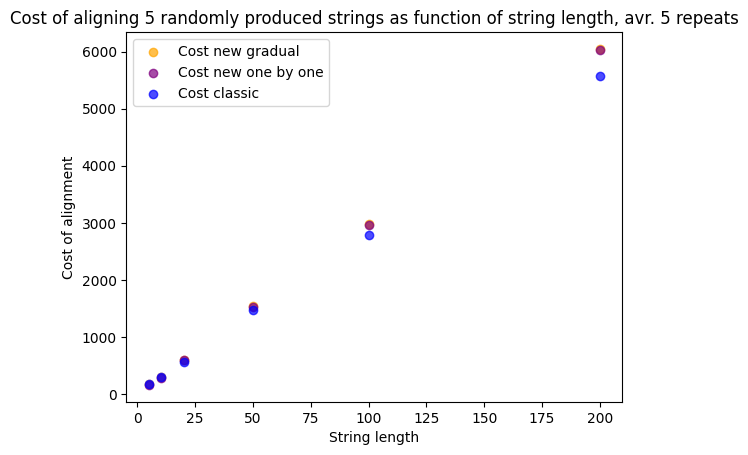

In [8]:
#chunk makes plot for all the random 5 str instances, as a function of str len
import matplotlib.pyplot as plt

average_values_random = df.groupby(['nr str', 'str len'])[['result_gradual', 'result_OBO', 'result_old']].mean().reset_index()


average_values_random

average_values_random_5_str=average_values_random[(average_values_random['nr str'] == '5')]

average_values_random_5_str['str len'] = pd.to_numeric(average_values_random_5_str['str len'])
plt.scatter(average_values_random_5_str['str len'], average_values_random_5_str['result_gradual'], label='result_gradual',color="orange", alpha=0.7)
plt.scatter(average_values_random_5_str['str len'], average_values_random_5_str['result_OBO'], label='result_OBO', color="purple", alpha= 0.7)
plt.scatter(average_values_random_5_str['str len'], average_values_random_5_str['result_old'], label='result_old', color="blue",alpha=0.7)
plt.xlabel('String length')
plt.ylabel('Cost of alignment')
plt.legend(["Cost new gradual", "Cost new one by one", "Cost classic"])
plt.title("Cost of aligning 5 randomly produced strings as function of string length, avr. 5 repeats")
plt.savefig('random_5_str_avr_costs.png')
plt.show()




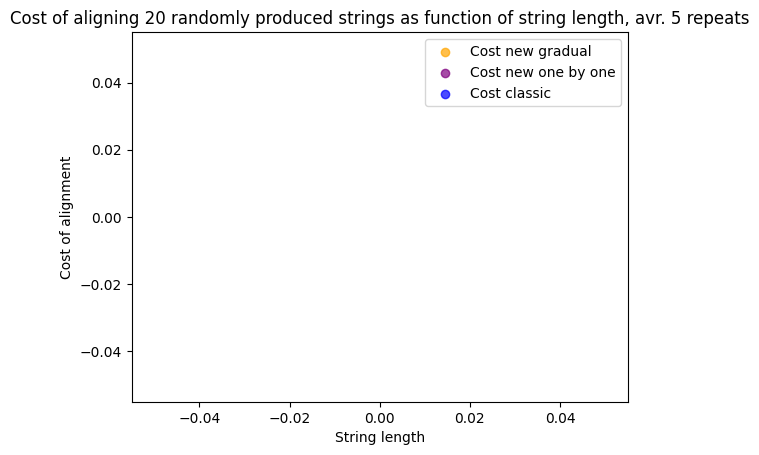

In [25]:
#chunk makes plot for all the random 5 str instances, as a function of str len
import matplotlib.pyplot as plt
import seaborn as sns

average_values_random = df.groupby(['nr str', 'str len'])[['result_gradual', 'result_OBO', 'result_old']].mean().reset_index()

average_values_random_20_str = average_values_random[(average_values_random['nr str'] == '20')]


average_values_random_20_str['str len'] = pd.to_numeric(average_values_random_20_str['str len'])
plt.scatter(average_values_random_20_str['str len'], average_values_random_20_str['result_gradual'], label='result_gradual',color="orange", alpha=0.7)
plt.scatter(average_values_random_20_str['str len'], average_values_random_20_str['result_OBO'], label='result_OBO', color="purple", alpha= 0.7)
plt.scatter(average_values_random_20_str['str len'], average_values_random_20_str['result_old'], label='result_old', color="blue",alpha=0.7)
plt.xlabel('String length')
plt.ylabel('Cost of alignment')
plt.legend(["Cost new gradual", "Cost new one by one", "Cost classic"])
plt.title("Cost of aligning 20 randomly produced strings as function of string length, avr. 5 repeats")
plt.savefig('random_20_str_avr_costs.png')
plt.show()

In [3]:
import pandas as pd
import re

# Specify the path to your CSV file
csv_file_path = 'output_testing_only_family_big_version_NEW_OBO.csv'

# Read the CSV file with a custom separator and no header
df = pd.read_csv(csv_file_path, sep='delimiter', header=None, engine='python')

# Extracting parameters and results using regular expressions
pattern = r'"nr str: (\S+), repeats: (\S+), str len: (\S+), nr fams: (\S+), str_pr_fam: (\S+), internal var: (.+), var between fams: (.+), mode:(\S+)","(\(.+\))"'
df = df[0].str.extract(pattern)

# Renaming columns
columns = ['nr str', 'repeats', 'str len', 'nr fams', 'str_pr_fam', 'internal var', 'var between fams', 'mode', 'results']
df.columns = columns

# Converting string representation of tuples to actual tuples
df['results'] = df['results'].apply(lambda x: eval(x))

df[['result_gradual', 'result_OBO', 'result_old']] = pd.DataFrame(df['results'].tolist(), index=df.index)
df.drop(columns=['results'], inplace=True)
df['result_gradual'] = df['result_gradual'].apply(lambda x: x[0])
df['result_OBO'] = df['result_OBO'].apply(lambda x: x[0])
df['result_old'] = df['result_old'].apply(lambda x: x[0])
display(df)


subset_of_fam_data=df[(df['nr fams'] == '2')&(df['str_pr_fam']=='5')]

subset_of_fam_data

,nr str,repeats,str len,nr fams,str_pr_fam,internal var,var between fams,mode,result_gradual,result_OBO,result_old
0,NA,5,5,2,2,0.1,0.1,family,21,21,21
1,NA,5,5,2,2,0.1,0.9,family,54,54,54
2,NA,5,5,2,2,0.9,0.1,family,75,75,75
3,NA,5,5,2,2,0.9,0.9,family,61,61,61
4,NA,5,5,2,5,0.1,0.1,family,80,80,80
...,...,...,...,...,...,...,...,...,...,...,...
235,NA,5,100,5,2,0.9,0.9,family,16265,16291,13677
236,NA,5,100,5,5,0.1,0.1,family,23010,23010,23010
237,NA,5,100,5,5,0.1,0.9,family,81104,81104,79607
238,NA,5,100,5,5,0.9,0.1,family,117129,116565,82221


,nr str,repeats,str len,nr fams,str_pr_fam,internal var,var between fams,mode,result_gradual,result_OBO,result_old
4,NA,5,5,2,5,0.1,0.1,family,80,80,80
5,NA,5,5,2,5,0.1,0.9,family,260,260,260
6,NA,5,5,2,5,0.9,0.1,family,596,596,613
7,NA,5,5,2,5,0.9,0.9,family,532,532,532
20,NA,5,20,2,5,0.1,0.1,family,427,427,427
21,NA,5,20,2,5,0.1,0.9,family,1301,1301,1317
22,NA,5,20,2,5,0.9,0.1,family,2995,2995,2401
23,NA,5,20,2,5,0.9,0.9,family,3395,3395,2820
36,NA,5,100,2,5,0.1,0.1,family,3121,3121,3121
37,NA,5,100,2,5,0.1,0.9,family,6352,6352,7264


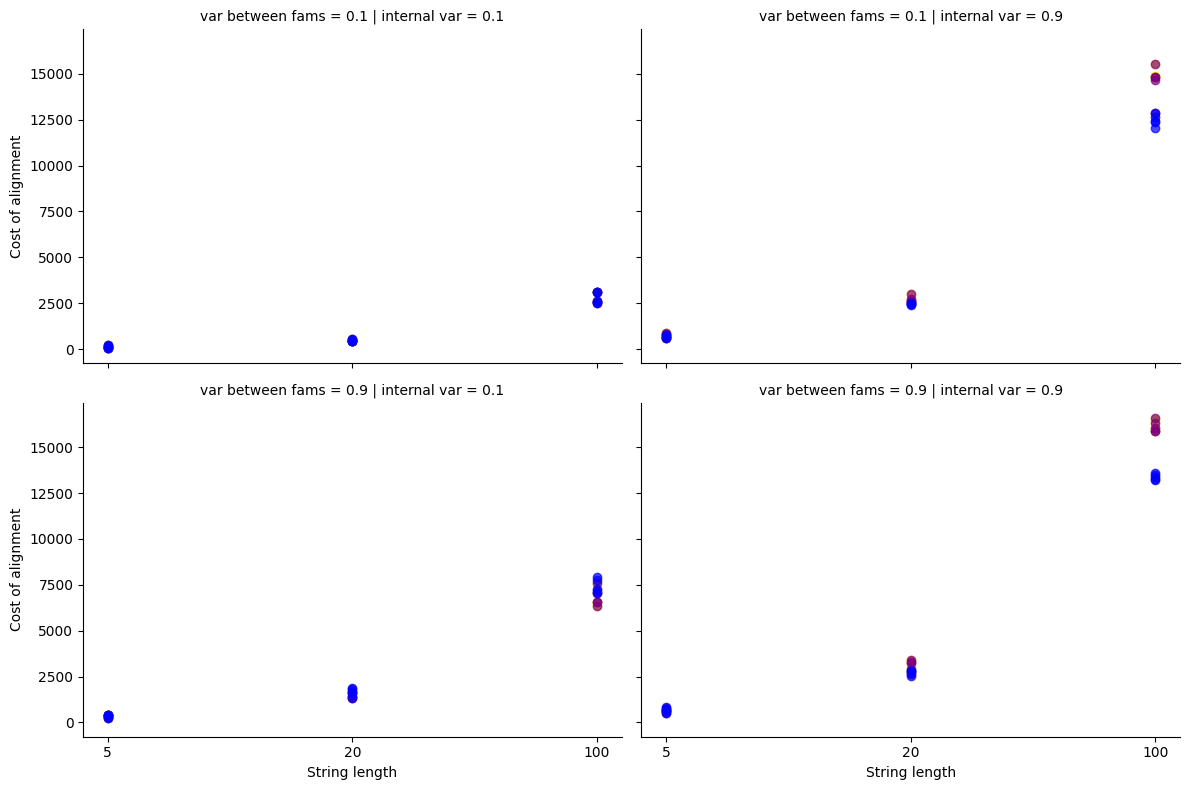

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

g=sns.FacetGrid(subset_of_fam_data, col="internal var", row="var between fams", height=4, aspect=1.5)
g.map(plt.scatter, "str len", "result_gradual", color='yellow', alpha=0.7)
g.map(plt.scatter, "str len", "result_OBO", color="purple", alpha=0.7)
g.map(plt.scatter, "str len", "result_old",color='blue', alpha=0.7)


g.set_axis_labels("String length", "Cost of alignment")

plt.savefig("var_in_fams.png")

plt.show()

